# 다중 객체 추적 (Multi-Object Tracking)

이 노트북에서는 LiDAR 포인트 클라우드 기반 객체 검출 결과를 활용하여 다중 객체 추적 방법을 학습하고 구현합니다.

## 학습 목표

- 다중 객체 추적(MOT)의 기본 개념 및 접근 방식 이해
- 데이터 연관성(Data Association) 알고리즘 구현
- 헝가리안 알고리즘(Hungarian Algorithm)을 활용한 객체 매칭
- 간단한 추적 관리 시스템 구현
- 추적 결과 시각화 및 성능 평가

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
from scipy.optimize import linear_sum_assignment
from collections import defaultdict
from matplotlib.patches import Rectangle, Polygon, Arrow
from filterpy.kalman import KalmanFilter
import time
import uuid

# 프로젝트 루트 경로 추가
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# 유틸리티 모듈 임포트
from utils.tracking import (
    associate_detections_to_tracks,
    update_tracks,
    predict_new_locations,
    kalman_filter_update,
    MultiObjectTracker,
    Track
)

from utils.visualization import (
    plot_bev,
    visualize_kalman_tracks
)

from utils.object_detection import (
    detect_objects
)

# 시각화 설정
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 1. 다중 객체 추적의 기본 개념

다중 객체 추적(Multi-Object Tracking, MOT)은 여러 객체의 시간에 따른 위치와 상태를 추적하는 작업입니다.
자율주행에서는 주변 차량, 보행자, 자전거 등의 움직임을 정확히 추적하여 충돌 방지 및 경로 계획에 활용합니다.

### MOT의 주요 구성 요소

1. **객체 검출**: 각 프레임에서 객체를 검출
2. **데이터 연관성**: 현재 프레임의 검출 결과와 기존 추적 객체 간의 매칭
3. **상태 추정**: 객체의 위치, 속도 등의 상태를 추정 (주로 칼만 필터 사용)
4. **추적 관리**: 새로운 추적 생성, 기존 추적 유지 또는 종료 결정

### 접근 방식

- **Tracking-by-Detection**: 객체 검출 후 추적 수행 (가장 일반적)
- **Joint Detection and Tracking**: 검출과 추적을 동시에 수행
- **End-to-End Tracking**: 딥러닝을 활용한 통합 추적

In [5]:
# 데이터 로드 함수
def load_point_cloud(bin_path):
    """
    KITTI bin 형식의 포인트 클라우드 파일 로드
    
    Args:
        bin_path (str): bin 파일 경로
        
    Returns:
        numpy.ndarray: 포인트 클라우드 [N, 4] (x, y, z, intensity)
    """
    # 이진 파일에서 4xN float 배열로 읽기
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return points

def load_image(img_path):
    """
    이미지 파일 로드
    
    Args:
        img_path (str): 이미지 파일 경로
        
    Returns:
        numpy.ndarray: RGB 이미지
    """
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
    return img

# Ground truth 데이터 로드 함수
def load_label(label_path):
    """
    KITTI 레이블 파일 로드
    
    Args:
        label_path (str): 레이블 파일 경로
        
    Returns:
        list: 객체 정보 리스트
    """
    objects = []
    
    if not os.path.exists(label_path):
        return objects
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
        
        for line in lines:
            line = line.strip().split(' ')
            
            obj = {
                'type': line[0],
                'truncated': float(line[1]),
                'occluded': int(line[2]),
                'alpha': float(line[3]),
                'bbox': [float(line[4]), float(line[5]), float(line[6]), float(line[7])],
                'dimensions': [float(line[8]), float(line[9]), float(line[10])],
                'location': [float(line[11]), float(line[12]), float(line[13])],
                'rotation_y': float(line[14])
            }
            
            if len(line) > 15:  # 추적 ID가 있는 경우
                obj['track_id'] = int(line[15])
            
            objects.append(obj)
    
    return objects

## 2. 데이터 로드

여러 프레임의 포인트 클라우드와 객체 검출 결과를 로드하여 추적 알고리즘을 테스트합니다.

프레임 000000 로드 중...
  포인트 개수: 115384
  객체 개수: 1
프레임 000001 로드 중...
  포인트 개수: 120268
  객체 개수: 7
프레임 000002 로드 중...
  포인트 개수: 126891
  객체 개수: 2
프레임 000003 로드 중...
  포인트 개수: 113110
  객체 개수: 3
프레임 000004 로드 중...
  포인트 개수: 115976
  객체 개수: 7
프레임 000005 로드 중...
  포인트 개수: 125086
  객체 개수: 5
프레임 000006 로드 중...
  포인트 개수: 110089
  객체 개수: 6
프레임 000007 로드 중...
  포인트 개수: 122798
  객체 개수: 6
프레임 000008 로드 중...
  포인트 개수: 122555
  객체 개수: 10
프레임 000009 로드 중...
  포인트 개수: 123928
  객체 개수: 5


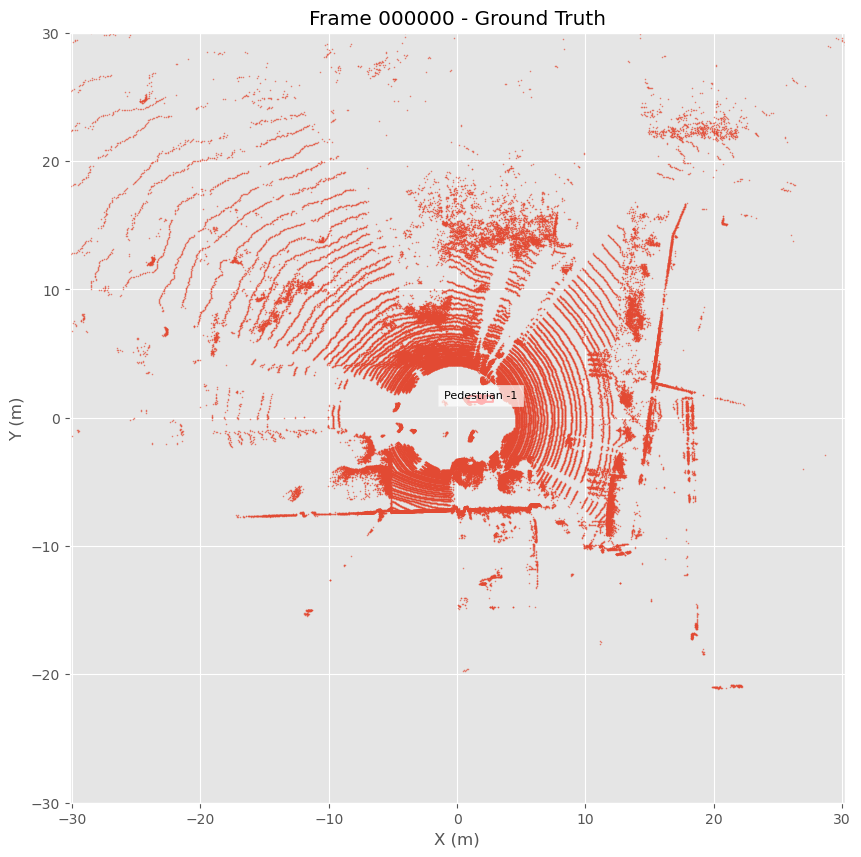

In [6]:
# 데이터 경로 설정
data_dir = '/home/shbyun/KITTI/ObjectDetection/'
point_cloud_dir = os.path.join(data_dir, 'data_object_velodyne/training', 'velodyne')
label_dir = os.path.join(data_dir, 'data_object_label_2/training', 'label_2')

# 테스트용 프레임 ID 정의
frame_ids = [f'{i:06d}' for i in range(0, 10)]  # 10개 프레임 사용

# 프레임 데이터 로드
frames_data = []
if os.path.exists(point_cloud_dir):
    for frame_id in frame_ids:
        point_cloud_path = os.path.join(point_cloud_dir, f'{frame_id}.bin')
        label_path = os.path.join(label_dir, f'{frame_id}.txt')
        
        if os.path.exists(point_cloud_path):
            print(f"프레임 {frame_id} 로드 중...")
            points = load_point_cloud(point_cloud_path)
            labels = load_label(label_path)
            
            frames_data.append({
                'frame_id': frame_id,
                'points': points,
                'labels': labels
            })
            print(f"  포인트 개수: {points.shape[0]}")
            print(f"  객체 개수: {len(labels)}")
        else:
            print(f"프레임 {frame_id} 파일을 찾을 수 없습니다.")
else:
    print("데이터 디렉토리를 찾을 수 없습니다. 예시 데이터를 생성합니다.")
    
    # 예시 프레임 데이터 생성
    for i in range(len(frame_ids)):
        frame_id = frame_ids[i]
        
        # 가상의 포인트 클라우드 생성
        num_points = 10000
        points = np.random.rand(num_points, 4) * 50 - 25  # -25 ~ 25 범위의 포인트
        points[:, 2] = points[:, 2] * 5 - 2  # z값은 -2 ~ 3 범위로 조정
        
        # 가상의 객체 생성
        labels = []
        # 첫 번째 객체 (정지 상태의 차량)
        obj1 = {
            'type': 'Car',
            'location': [10.0, 0.0, 0.0],
            'dimensions': [4.0, 1.8, 1.5],
            'rotation_y': 0.0,
            'track_id': 1
        }
        
        # 두 번째 객체 (이동하는 차량)
        obj2_x = -5.0 + i * 2.0  # 프레임마다 x 좌표 이동
        obj2 = {
            'type': 'Car',
            'location': [obj2_x, 10.0, 0.0],
            'dimensions': [4.5, 2.0, 1.7],
            'rotation_y': np.pi/4,
            'track_id': 2
        }
        
        # 세 번째 객체 (이동하는 보행자)
        obj3_y = -8.0 + i * 1.0  # 프레임마다 y 좌표 이동
        obj3 = {
            'type': 'Pedestrian',
            'location': [5.0, obj3_y, 0.0],
            'dimensions': [0.6, 0.8, 1.7],
            'rotation_y': 0.0,
            'track_id': 3
        }
        
        labels.extend([obj1, obj2, obj3])
        
        frames_data.append({
            'frame_id': frame_id,
            'points': points,
            'labels': labels
        })
        
        print(f"프레임 {frame_id} 가상 데이터 생성 완료")
        print(f"  포인트 개수: {points.shape[0]}")
        print(f"  객체 개수: {len(labels)}")

# 첫 번째 프레임의 데이터 시각화
if frames_data:
    first_frame = frames_data[0]
    points = first_frame['points']
    labels = first_frame['labels']
    
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1], s=0.5, alpha=0.5)
    
    # 레이블 객체 표시
    for obj in labels:
        if 'location' in obj:
            loc = obj['location']
            plt.scatter(loc[0], loc[1], s=50, c='red')
            
            if 'dimensions' in obj:
                dim = obj['dimensions']
                length, width = dim[0], dim[1]
                
                # 회전 각도
                rot_y = obj.get('rotation_y', 0.0)
                
                # 바운딩 박스 코너 계산
                corners = np.array([
                    [-length/2, -width/2],
                    [length/2, -width/2],
                    [length/2, width/2],
                    [-length/2, width/2],
                    [-length/2, -width/2]  # 첫 점 반복하여 폐곡선 형성
                ])
                
                # 회전 행렬
                rot_mat = np.array([
                    [np.cos(rot_y), -np.sin(rot_y)],
                    [np.sin(rot_y), np.cos(rot_y)]
                ])
                
                # 회전 및 이동
                corners = corners @ rot_mat.T + loc[:2]
                
                # 바운딩 박스 그리기
                plt.plot(corners[:, 0], corners[:, 1], '-r')
                
                # 객체 타입 및 ID 표시
                obj_type = obj.get('type', 'Unknown')
                track_id = obj.get('track_id', -1)
                plt.text(loc[0], loc[1], f"{obj_type} {track_id}", fontsize=8,
                         ha='center', bbox=dict(facecolor='white', alpha=0.7))
    
    plt.title(f"Frame {first_frame['frame_id']} - Ground Truth")
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.axis('equal')
    plt.grid(True)
    plt.xlim([-30, 30])
    plt.ylim([-30, 30])
    plt.show()

## 3. 데이터 연관성 (Data Association)

데이터 연관성은 현재 프레임의 검출 결과와 기존 추적 객체 간의 매칭을 수행하는 과정입니다.
이를 통해 각 객체의 궤적을 유지하고 ID를 일관되게 관리할 수 있습니다.

### 데이터 연관성 방법

1. **IoU(Intersection over Union) 기반 매칭**: 바운딩 박스의 중첩 정도를 기준으로 매칭
2. **거리 기반 매칭**: 객체 중심 간의 유클리디안 거리를 기준으로 매칭
3. **특징 기반 매칭**: 외형적 특징 유사도를 기준으로 매칭
4. **모션 기반 매칭**: 이동 방향과 속도를 고려한 매칭

In [7]:
# IoU 계산 함수
def calculate_iou(box1, box2):
    """
    두 박스 간의 IoU(Intersection over Union)를 계산
    
    Args:
        box1 (numpy.ndarray): [x_min, y_min, x_max, y_max] 형태의 박스
        box2 (numpy.ndarray): [x_min, y_min, x_max, y_max] 형태의 박스
        
    Returns:
        float: IoU 값 (0~1)
    """
    # 교차 영역 계산
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])
    
    # 교차 영역이 없는 경우
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # 교차 영역 넓이
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # 각 박스의 넓이
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # 합집합 넓이
    union_area = box1_area + box2_area - intersection_area
    
    # IoU 계산
    iou = intersection_area / union_area
    
    return iou

# 객체 중심 간 거리 계산 함수
def calculate_distance(center1, center2):
    """
    두 중심 간의 유클리디안 거리 계산
    
    Args:
        center1 (numpy.ndarray): [x, y, z] 형태의 중심 좌표
        center2 (numpy.ndarray): [x, y, z] 형태의 중심 좌표
        
    Returns:
        float: 유클리디안 거리
    """
    return np.linalg.norm(center1 - center2)

# 비용 행렬 계산 함수
def compute_cost_matrix(detections, tracks, method='distance'):
    """
    검출 결과와 추적 객체 간의 비용 행렬 계산
    
    Args:
        detections (list): 검출 객체 리스트
        tracks (list): 추적 객체 리스트
        method (str): 비용 계산 방법 ('iou' 또는 'distance')
        
    Returns:
        numpy.ndarray: 비용 행렬
    """
    cost_matrix = np.zeros((len(tracks), len(detections)))
    
    for i, track in enumerate(tracks):
        for j, detection in enumerate(detections):
            if method == 'iou':
                # IoU 기반 비용 (1 - IoU)
                track_box = track.get('bbox', [0, 0, 0, 0])
                det_box = detection.get('bbox', [0, 0, 0, 0])
                cost_matrix[i, j] = 1.0 - calculate_iou(track_box, det_box)
            else:
                # 거리 기반 비용
                track_center = track.get('center', np.zeros(3))
                det_center = detection.get('center', np.zeros(3))
                cost_matrix[i, j] = calculate_distance(track_center, det_center)
    
    return cost_matrix

# 헝가리안 알고리즘을 이용한 데이터 연관성
def associate_detections_to_tracks_hungarian(detections, tracks, cost_threshold=50.0):
    """
    헝가리안 알고리즘을 이용한 검출과 추적 객체 연관성 수립
    
    Args:
        detections (list): 검출 객체 리스트
        tracks (list): 추적 객체 리스트
        cost_threshold (float): 비용 임계값 (이 값보다 큰 비용은 연관성을 가지지 않음)
        
    Returns:
        tuple: (matched_indices, unmatched_detections, unmatched_tracks)
    """
    if len(tracks) == 0:
        return np.array([]), list(range(len(detections))), []
        
    if len(detections) == 0:
        return np.array([]), [], list(range(len(tracks)))
    
    # 비용 행렬 계산
    cost_matrix = compute_cost_matrix(detections, tracks)
    
    # 헝가리안 알고리즘 적용
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # 매칭된 인덱스 리스트
    matched_indices = []
    for row, col in zip(row_indices, col_indices):
        if cost_matrix[row, col] < cost_threshold:
            matched_indices.append((row, col))
    
    # 매칭되지 않은 검출 객체
    if len(matched_indices) > 0:
        matched_indices = np.array(matched_indices)
        unmatched_detections = [i for i in range(len(detections)) if i not in matched_indices[:, 1]]
        unmatched_tracks = [i for i in range(len(tracks)) if i not in matched_indices[:, 0]]
    else:
        matched_indices = np.array([])
        unmatched_detections = list(range(len(detections)))
        unmatched_tracks = list(range(len(tracks)))
    
    return matched_indices, unmatched_detections, unmatched_tracks

## 4. 칼만 필터 기반 상태 추정

칼만 필터는 시스템의 이전 상태와 현재 측정값을 사용하여 현재 상태를 추정하는 재귀적 필터입니다.
객체 추적에서는 위치와 속도 등의 상태를 추정하는 데 주로 사용됩니다.

### 칼만 필터 단계

1. **예측(Prediction)**: 이전 상태와 모션 모델을 기반으로 현재 상태 예측
2. **업데이트(Update)**: 측정값을 사용하여 예측된 상태를 업데이트

In [8]:
class KalmanTracker:
    """
    칼만 필터를 사용한 단일 객체 추적기
    """
    def __init__(self, detection, track_id=None):
        """
        추적기 초기화
        
        Args:
            detection (dict): 초기 검출 정보
            track_id (int): 추적 ID (없으면 자동 생성)
        """
        # 추적 ID 설정
        self.id = track_id if track_id is not None else np.random.randint(100000)
        
        # 추적 상태 정보
        self.age = 1  # 추적 나이
        self.hits = 1  # 검출 적중 횟수
        self.time_since_update = 0  # 마지막 업데이트 이후 경과 프레임
        self.state = "tentative"  # 추적 상태 (tentative, confirmed, deleted)
        
        # 검출 정보 저장
        self.center = detection.get('center', np.zeros(3))
        self.dimensions = detection.get('dimensions', np.zeros(3))
        self.class_name = detection.get('class', 'unknown')
        
        # 칼만 필터 초기화
        self.kf = self._init_kf(self.center)
        
        # 궤적 저장
        self.history = [self.center.copy()]
    
    def _init_kf(self, center):
        """
        칼만 필터 초기화
        
        Args:
            center (numpy.ndarray): 초기 위치 [x, y, z]
            
        Returns:
            KalmanFilter: 초기화된 칼만 필터
        """
        # 상태 벡터: [x, y, z, vx, vy, vz]
        kf = KalmanFilter(dim_x=6, dim_z=3)
        
        # 초기 상태 설정
        kf.x = np.array([center[0], center[1], center[2], 0, 0, 0])
        
        # 상태 전이 행렬 (F)
        dt = 0.1  # 시간 간격 (가정)
        kf.F = np.array([
            [1, 0, 0, dt, 0, 0],
            [0, 1, 0, 0, dt, 0],
            [0, 0, 1, 0, 0, dt],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1]
        ])
        
        # 측정 행렬 (H)
        kf.H = np.array([
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0]
        ])
        
        # 측정 노이즈 (R)
        kf.R = np.eye(3) * 0.1
        
        # 프로세스 노이즈 (Q)
        q = Q_discrete_white_noise(dim=3, dt=dt, var=0.01)
        kf.Q = block_diag(q, q)
        
        # 오차 공분산 행렬 (P)
        kf.P = np.eye(6) * 10
        
        return kf
    
    def predict(self):
        """
        다음 상태 예측
        
        Returns:
            numpy.ndarray: 예측된 위치 [x, y, z]
        """
        self.kf.predict()
        self.age += 1
        self.time_since_update += 1
        
        # 현재 위치 업데이트
        self.center = self.kf.x[:3]
        
        # 궤적에 추가
        self.history.append(self.center.copy())
        
        return self.center
    
    def update(self, detection):
        """
        검출 정보로 상태 업데이트
        
        Args:
            detection (dict): 검출 정보
            
        Returns:
            numpy.ndarray: 업데이트된 위치 [x, y, z]
        """
        # 검출 중심 좌표
        measurement = detection.get('center', np.zeros(3))
        
        # 칼만 필터 업데이트
        self.kf.update(measurement)
        
        # 상태 업데이트
        self.hits += 1
        self.time_since_update = 0
        
        # 충분히 검출되면 confirmed 상태로 변경
        if self.hits >= 3 and self.state == "tentative":
            self.state = "confirmed"
        
        # 현재 위치 업데이트
        self.center = self.kf.x[:3]
        
        # 객체 크기 업데이트 (지수 이동 평균 사용)
        alpha = 0.7  # 스무딩 계수
        new_dim = detection.get('dimensions', self.dimensions)
        self.dimensions = alpha * self.dimensions + (1 - alpha) * new_dim
        
        # 클래스 업데이트 (기존 클래스 유지할 확률이 높음)
        if self.hits <= 3:  # 초기에만 클래스 업데이트
            self.class_name = detection.get('class', self.class_name)
        
        return self.center
    
    def get_state(self):
        """
        현재 상태 반환
        
        Returns:
            dict: 현재 상태 정보
        """
        velocity = self.kf.x[3:6]
        speed = np.linalg.norm(velocity)
        
        return {
            'id': self.id,
            'center': self.center,
            'dimensions': self.dimensions,
            'velocity': velocity,
            'speed': speed,
            'class': self.class_name,
            'age': self.age,
            'time_since_update': self.time_since_update,
            'state': self.state,
            'history': self.history
        }

# 간단한 BlockDiag 및 Q_discrete_white_noise 함수 (filterpy 라이브러리가 없을 경우 대체)
def block_diag(a, b):
    """
    두 행렬을 블록 대각행렬로 결합
    """
    rows_a, cols_a = a.shape
    rows_b, cols_b = b.shape
    
    result = np.zeros((rows_a + rows_b, cols_a + cols_b))
    result[:rows_a, :cols_a] = a
    result[rows_a:, cols_a:] = b
    
    return result

def Q_discrete_white_noise(dim, dt, var):
    """
    이산 시간 백색 노이즈 프로세스 노이즈 행렬 생성
    """
    if dim == 1:
        Q = np.array([[var]])
    elif dim == 2:
        Q = np.array([
            [0.25*dt**4, 0.5*dt**3],
            [0.5*dt**3, dt**2]
        ]) * var
    elif dim == 3:
        Q = np.array([
            [0.25*dt**4, 0.5*dt**3, 0.5*dt**2],
            [0.5*dt**3, dt**2, dt],
            [0.5*dt**2, dt, 1]
        ]) * var
    else:
        raise ValueError(f"Unsupported dimension: {dim}")
    
    return Q


## 5. 다중 객체 추적기 구현

여러 객체를 동시에 추적하기 위한 다중 객체 추적기(MOT)를 구현합니다.
이 추적기는 다음 기능들을 포함합니다:

1. **추적 생성**: 새로운 객체 검출 시 추적 생성
2. **추적 업데이트**: 연관된 검출 결과로 기존 추적 업데이트
3. **추적 삭제**: 오랫동안 업데이트되지 않은 추적 삭제

In [9]:
class MultiObjectTracker2:
    """
    다중 객체 추적기
    """
    def __init__(self, max_age=10, min_hits=3, cost_threshold=30.0):
        """
        다중 객체 추적기 초기화
        
        Args:
            max_age (int): 추적 삭제 전 최대 미검출 프레임 수
            min_hits (int): 추적 확정 전 최소 검출 횟수
            cost_threshold (float): 연관성 최대 비용 임계값
        """
        self.max_age = max_age
        self.min_hits = min_hits
        self.cost_threshold = cost_threshold
        self.trackers = []  # 추적기 목록
        self.frame_count = 0  # 프레임 카운터
        self.track_id_count = 0  # 추적 ID 카운터
    
    def update(self, detections):
        """
        새로운 프레임의 검출 결과로 추적기 업데이트
        
        Args:
            detections (list): 검출 객체 리스트
            
        Returns:
            list: 업데이트된 추적 상태 리스트
        """
        self.frame_count += 1
        
        # 예측 단계: 모든 추적기의 상태 예측
        for tracker in self.trackers:
            tracker.predict()
        
        # 현재 추적 상태
        tracked_objects = [t.get_state() for t in self.trackers]
        
        # 데이터 연관성: 검출과 추적 객체 매칭
        matched_indices, unmatched_detections, unmatched_tracks = \
            associate_detections_to_tracks_hungarian(
                detections, tracked_objects, self.cost_threshold)
        
        # 매칭된 추적 업데이트
        for track_idx, det_idx in matched_indices:
            self.trackers[track_idx].update(detections[det_idx])
        
        # 새로운 추적 생성
        for idx in unmatched_detections:
            self.track_id_count += 1
            new_tracker = KalmanTracker(detections[idx], self.track_id_count)
            self.trackers.append(new_tracker)
        
        # 오래된 추적 제거
        self.trackers = [t for t in self.trackers 
                         if t.time_since_update <= self.max_age]
        
        # 추적 결과 반환
        results = []
        for tracker in self.trackers:
            if tracker.time_since_update == 0 and tracker.hits >= self.min_hits:
                # confirmed 상태의 추적만 반환
                results.append(tracker.get_state())
        
        return results
        

## 6. 다중 객체 추적 구현 및 실행

구현한 다중 객체 추적기를 사용하여 연속된 프레임에서 객체를 추적하고 결과를 시각화합니다.

프레임 000000 처리 중...
  검출 객체 수: 1
  추적 객체 수: 0


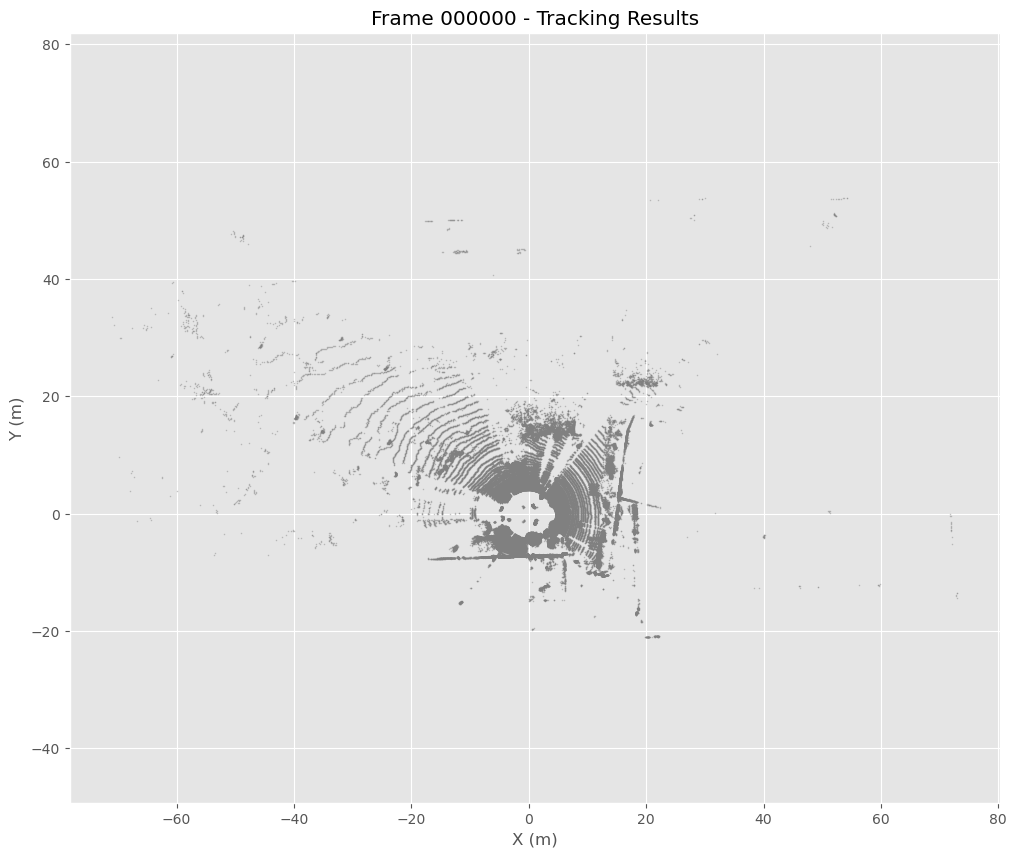

프레임 000001 처리 중...
  검출 객체 수: 7
  추적 객체 수: 0


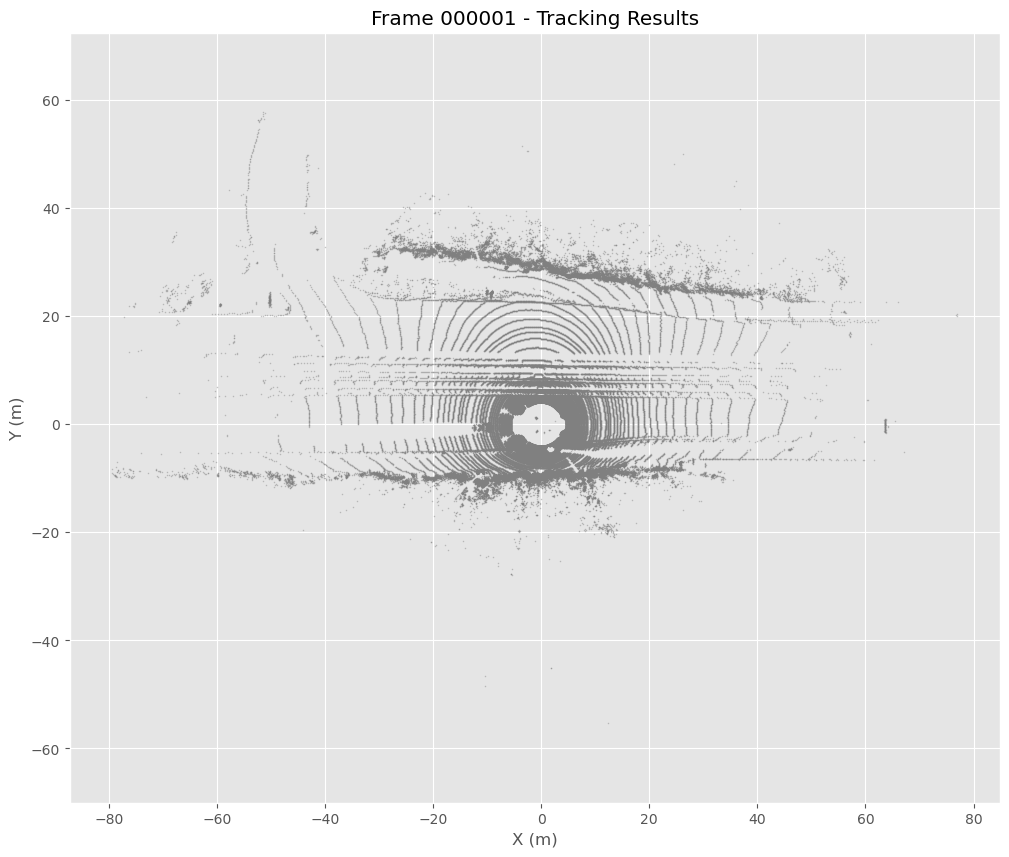

프레임 000002 처리 중...
  검출 객체 수: 2
  추적 객체 수: 0


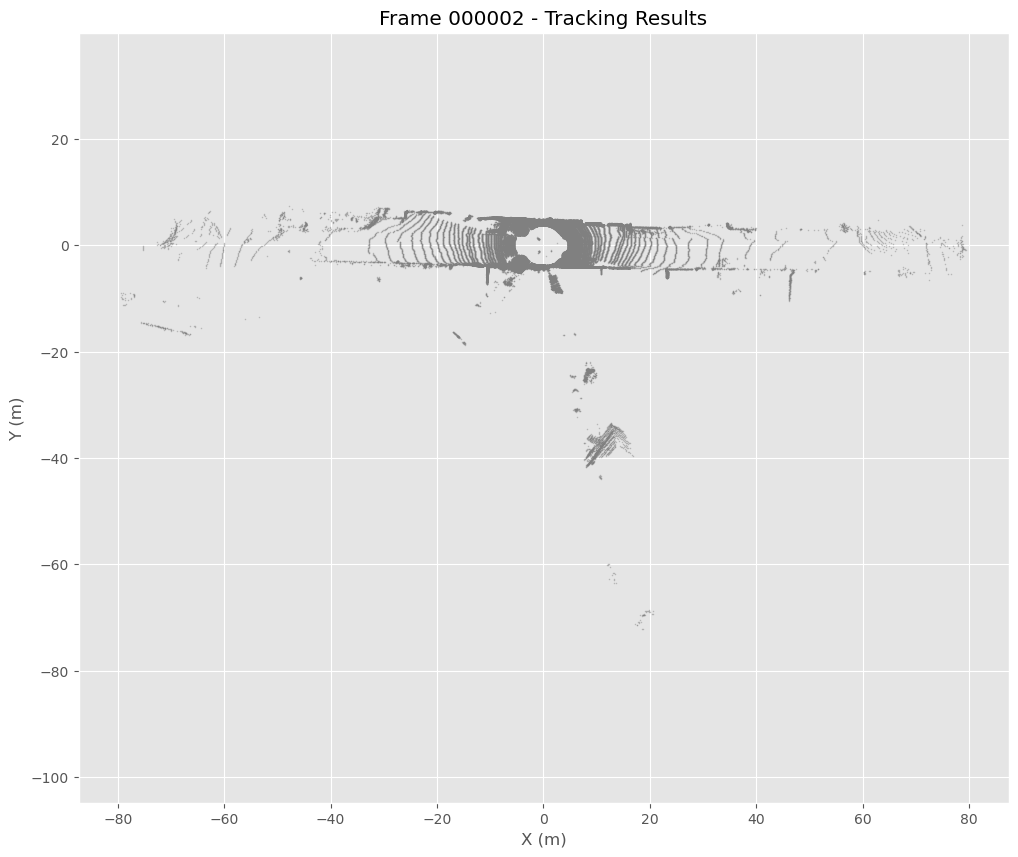

프레임 000003 처리 중...
  검출 객체 수: 3
  추적 객체 수: 0


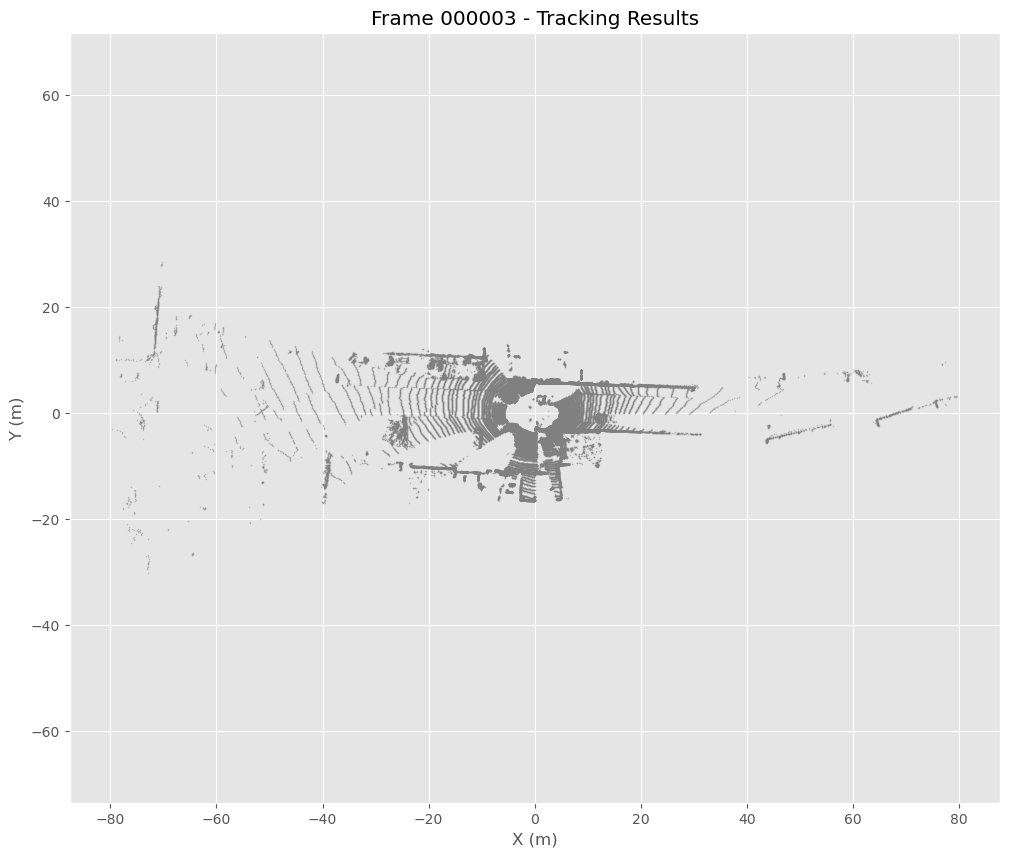

프레임 000004 처리 중...
  검출 객체 수: 7
  추적 객체 수: 2


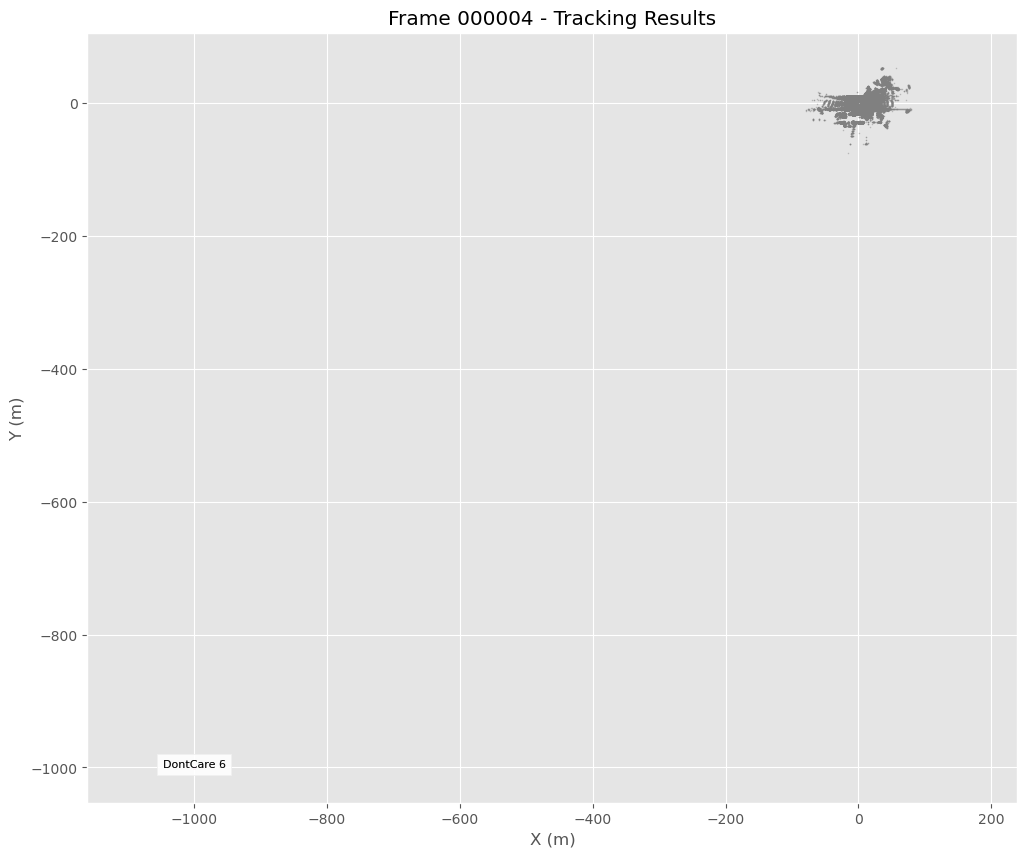

프레임 000005 처리 중...
  검출 객체 수: 5
  추적 객체 수: 4


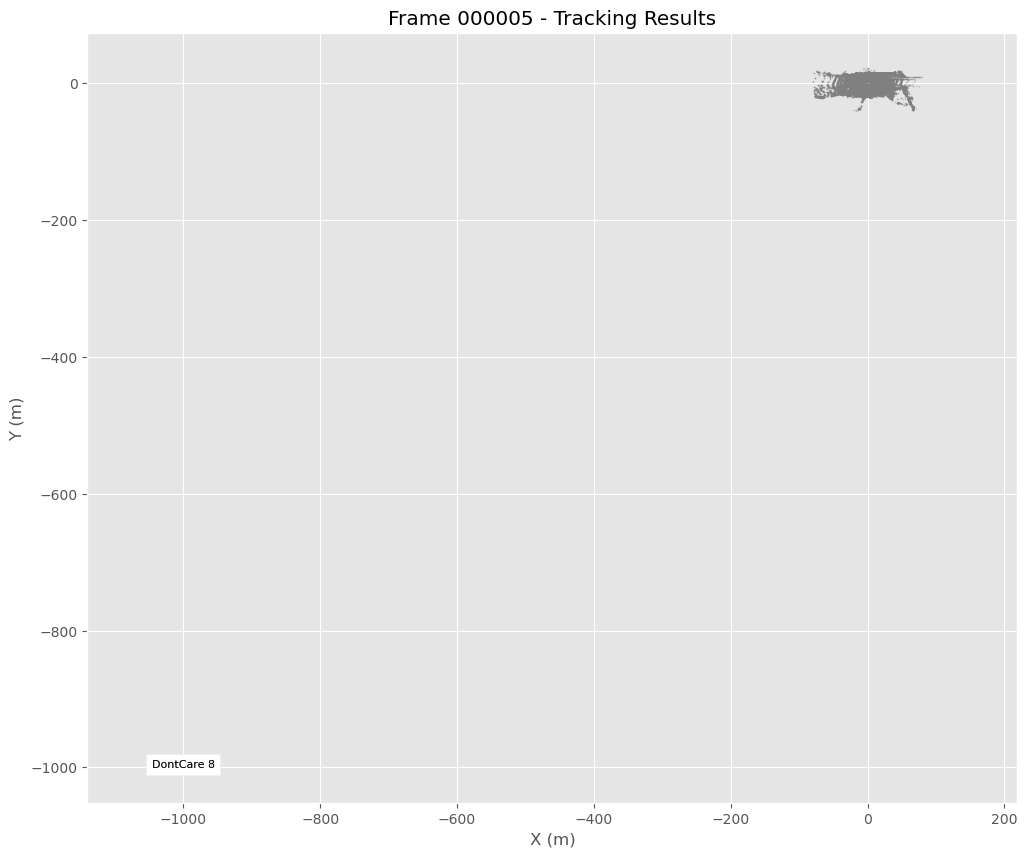

프레임 000006 처리 중...
  검출 객체 수: 6
  추적 객체 수: 2


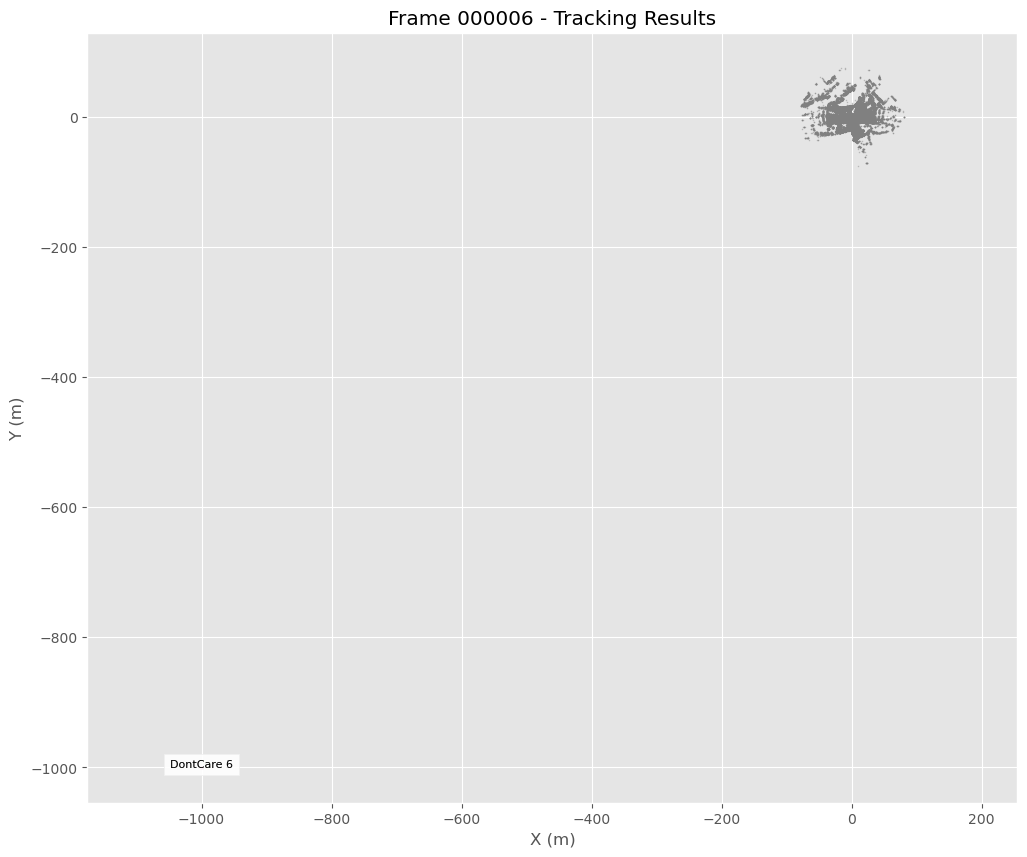

프레임 000007 처리 중...
  검출 객체 수: 6
  추적 객체 수: 3


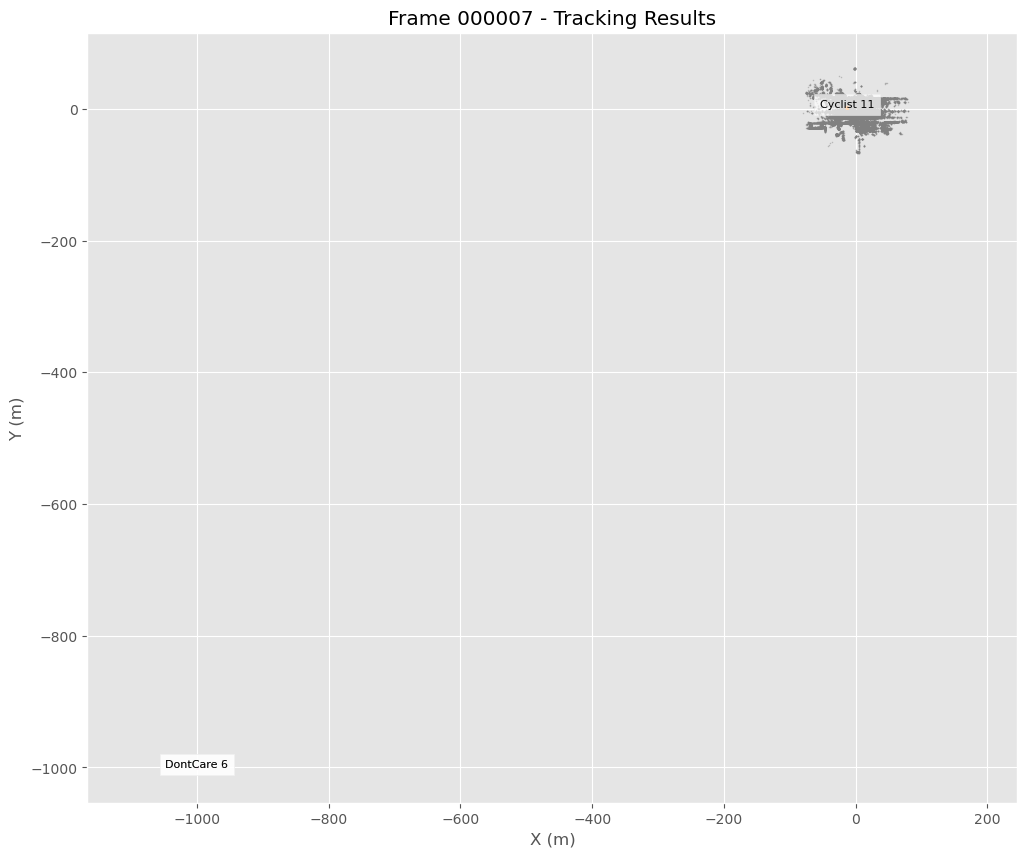

프레임 000008 처리 중...
  검출 객체 수: 10
  추적 객체 수: 5


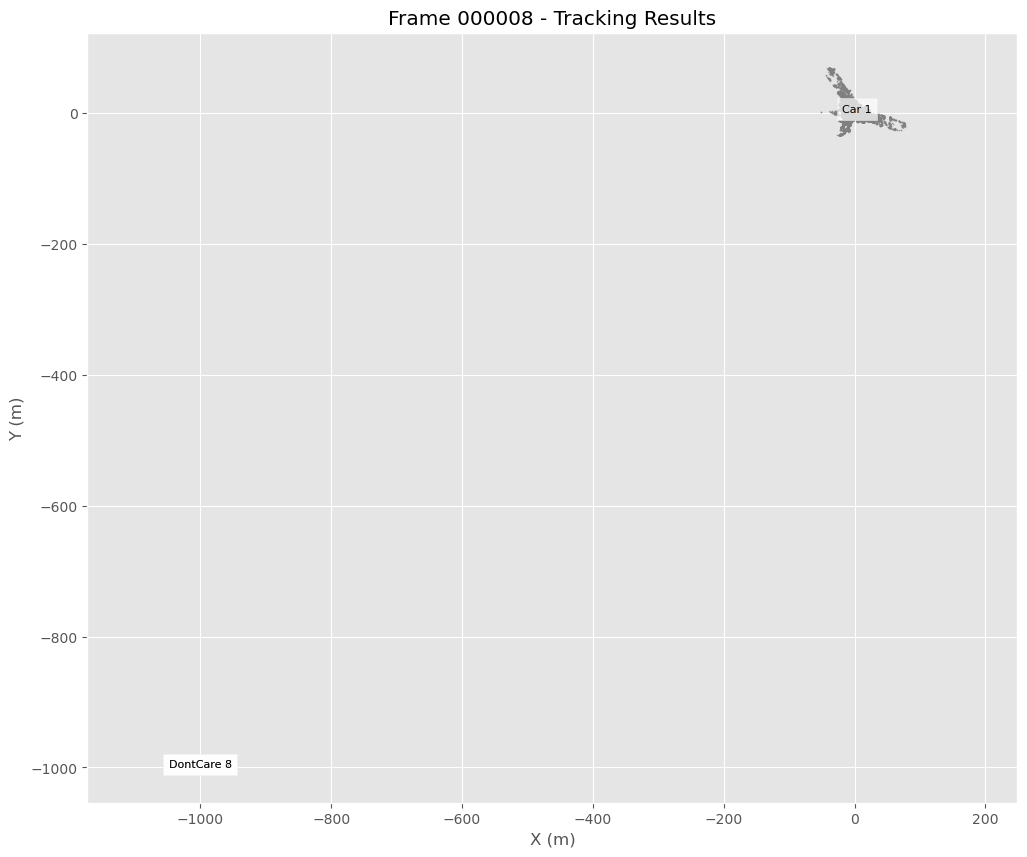

프레임 000009 처리 중...
  검출 객체 수: 5
  추적 객체 수: 2


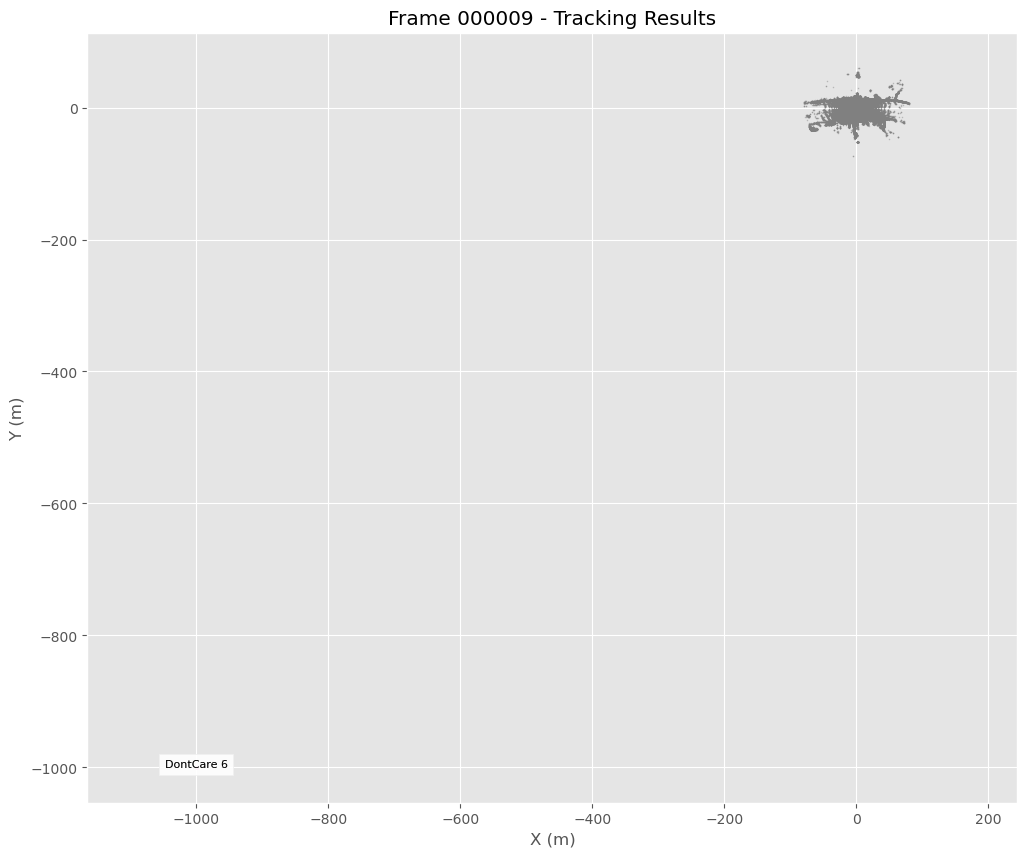

총 10개 프레임 처리 완료


In [10]:
# 검출 객체를 추적기 입력 형식으로 변환
def convert_detections(objects):
    """
    객체 검출 결과를 추적기 입력 형식으로 변환
    
    Args:
        objects (list): 검출 객체 리스트
        
    Returns:
        list: 변환된 검출 객체 리스트
    """
    detections = []
    
    for obj in objects:
        # 필요한 정보 추출
        if 'location' in obj:
            center = np.array(obj['location'])
            dimensions = np.array(obj.get('dimensions', [1.0, 1.0, 1.0]))
            class_name = obj.get('type', 'unknown')
            
            # 검출 객체 생성
            detection = {
                'center': center,
                'dimensions': dimensions,
                'class': class_name
            }
            
            detections.append(detection)
    
    return detections

# 추적 결과 시각화
def visualize_tracking_results(points, tracking_results, frame_id, xlim=(-30, 30), ylim=(-30, 30)):
    """
    추적 결과를 시각화
    
    Args:
        points (numpy.ndarray): 포인트 클라우드
        tracking_results (list): 추적 결과 리스트
        frame_id (str): 프레임 ID
        xlim (tuple): X축 범위
        ylim (tuple): Y축 범위
    """
    plt.figure(figsize=(12, 10))
    
    # 포인트 클라우드 그리기
    plt.scatter(points[:, 0], points[:, 1], s=0.5, alpha=0.3, c='gray')
    
    # 추적 객체 그리기
    for track in tracking_results:
        # 위치 및 ID
        center = track['center']
        track_id = track['id']
        dimensions = track['dimensions']
        velocity = track.get('velocity', np.zeros(3))
        class_name = track.get('class', 'unknown')
        
        # 객체 색상 (ID에 따라 다르게)
        color = plt.cm.tab10(track_id % 10)
        
        # 객체 바운딩 박스 그리기
        l, w = dimensions[0], dimensions[1]
        
        # 속도 기반 방향 계산
        if np.linalg.norm(velocity[:2]) > 0.1:
            heading = np.arctan2(velocity[1], velocity[0])
        else:
            heading = 0.0
        
        # 회전 행렬
        rot_mat = np.array([
            [np.cos(heading), -np.sin(heading)],
            [np.sin(heading), np.cos(heading)]
        ])
        
        # 바운딩 박스 코너 계산
        corners = np.array([
            [-l/2, -w/2],
            [l/2, -w/2],
            [l/2, w/2],
            [-l/2, w/2],
            [-l/2, -w/2]  # 첫 점 반복하여 폐곡선 형성
        ])
        
        # 회전 및 이동
        corners = corners @ rot_mat.T + center[:2]
        
        # 바운딩 박스 그리기
        plt.plot(corners[:, 0], corners[:, 1], '-', color=color, linewidth=2)
        
        # 속도 벡터 그리기
        plt.arrow(center[0], center[1], velocity[0], velocity[1], 
                 head_width=0.5, head_length=0.7, fc=color, ec=color, alpha=0.7)
        
        # 객체 정보 표시
        plt.text(center[0], center[1], f"{class_name} {track_id}", fontsize=8,
                ha='center', bbox=dict(facecolor='white', alpha=0.7))
        
        # 궤적 그리기
        history = track.get('history', [])
        if len(history) > 1:
            history_array = np.array(history)
            plt.plot(history_array[:, 0], history_array[:, 1], '-', 
                   color=color, alpha=0.5, linewidth=1)
    
    plt.title(f"Frame {frame_id} - Tracking Results")
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# 다중 객체 추적기 실행
def run_multi_object_tracking(frames_data):
    """
    연속된 프레임에서 다중 객체 추적 실행
    
    Args:
        frames_data (list): 프레임 데이터 리스트
        
    Returns:
        list: 각 프레임의 추적 결과
    """
    # 다중 객체 추적기 초기화
    mot = MultiObjectTracker2(max_age=5, min_hits=3, cost_threshold=5.0)
    
    all_tracking_results = []
    
    for frame_data in frames_data:
        frame_id = frame_data['frame_id']
        points = frame_data['points']
        
        # 검출 객체 변환 (실제로는 여기서 객체 검출 알고리즘 실행)
        # 이 예제에서는 ground truth를 검출 결과로 사용
        detections = convert_detections(frame_data['labels'])
        
        print(f"프레임 {frame_id} 처리 중...")
        print(f"  검출 객체 수: {len(detections)}")
        
        # 추적기 업데이트
        tracking_results = mot.update(detections)
        print(f"  추적 객체 수: {len(tracking_results)}")
        
        # 결과 저장
        all_tracking_results.append({
            'frame_id': frame_id,
            'tracking_results': tracking_results
        })
        
        # 추적 결과 시각화
        visualize_tracking_results(points, tracking_results, frame_id)
    
    return all_tracking_results

# 추적 실행
if frames_data:
    tracking_results = run_multi_object_tracking(frames_data)
    print(f"총 {len(tracking_results)}개 프레임 처리 완료")

## 7. 추적 성능 평가

객체 추적 결과의 성능을 평가하기 위한 다양한 지표를 계산하고 분석합니다.

### 주요 평가 지표

1. **MOTA (Multi-Object Tracking Accuracy)**: 전체 추적 정확도를 나타내는 지표
2. **MOTP (Multi-Object Tracking Precision)**: 위치 추정의 정밀도를 나타내는 지표
3. **ID 스위치**: 동일 객체의 ID가 변경된 횟수
4. **단편화(Fragmentation)**: 동일 궤적이 여러 부분으로 나뉜 횟수

===== 추적 성능 평가 =====
전체 객체 수: 52
TP (정확한 추적): 8
FP (잘못된 추적): 10
FN (놓친 객체): 44
ID 스위치: 7
MOTA: -0.1731
정밀도(Precision): 0.4444
재현율(Recall): 0.1538
F1 점수: 0.2286


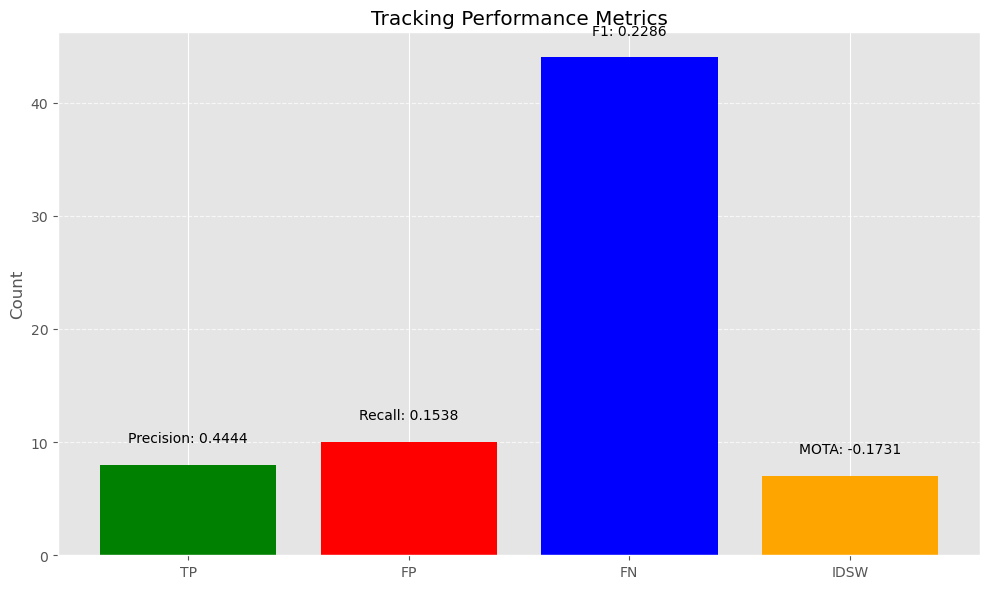

In [11]:
# 추적 결과와 Ground Truth 비교
def evaluate_tracking_results(tracking_results, ground_truth):
    """
    추적 결과의 성능 평가
    
    Args:
        tracking_results (list): 추적 결과 리스트
        ground_truth (list): Ground Truth 리스트
        
    Returns:
        dict: 성능 평가 지표
    """
    # 평가 지표 초기화
    metrics = {
        'TP': 0,  # True Positive (정확한 추적)
        'FP': 0,  # False Positive (잘못된 추적)
        'FN': 0,  # False Negative (놓친 객체)
        'IDSW': 0,  # ID 스위치
        'total_objects': 0  # 전체 객체 수
    }
    
    # 각 프레임별 평가
    for frame_idx in range(len(tracking_results)):
        # 현재 프레임의 추적 결과와 Ground Truth
        curr_tracks = tracking_results[frame_idx]['tracking_results']
        curr_gt = ground_truth[frame_idx]
        
        # Ground Truth 객체 수
        metrics['total_objects'] += len(curr_gt)
        
        # 추적 결과와 Ground Truth 매칭
        matched_gt = set()
        
        for track in curr_tracks:
            # 가장 가까운 Ground Truth 찾기
            min_dist = float('inf')
            best_match = None
            
            for gt_idx, gt in enumerate(curr_gt):
                # 위치 거리 계산
                track_center = track['center']
                gt_center = np.array(gt.get('location', [0, 0, 0]))
                
                dist = np.linalg.norm(track_center - gt_center)
                
                # 가장 가까운 매칭 업데이트
                if dist < min_dist and dist < 2.0:  # 2m 이내만 고려
                    min_dist = dist
                    best_match = gt_idx
            
            # 매칭 결과 처리
            if best_match is not None and best_match not in matched_gt:
                metrics['TP'] += 1
                matched_gt.add(best_match)
                
                # ID 스위치 확인 (이전 프레임과 비교)
                if frame_idx > 0:
                    prev_tracks = tracking_results[frame_idx-1]['tracking_results']
                    prev_matched_id = None
                    
                    # 이전 프레임에서 같은 GT에 매칭된 트랙 ID 찾기
                    for prev_track in prev_tracks:
                        for prev_gt_idx, prev_gt in enumerate(ground_truth[frame_idx-1]):
                            if prev_gt.get('track_id') == curr_gt[best_match].get('track_id'):
                                if np.linalg.norm(prev_track['center'] - np.array(prev_gt.get('location', [0, 0, 0]))) < 2.0:
                                    prev_matched_id = prev_track['id']
                                    break
                    
                    # ID 스위치 발생 여부 확인
                    if prev_matched_id is not None and prev_matched_id != track['id']:
                        metrics['IDSW'] += 1
            else:
                metrics['FP'] += 1
        
        # 놓친 객체 (False Negative) 계산
        metrics['FN'] += len(curr_gt) - len(matched_gt)
    
    # MOTA 계산
    if metrics['total_objects'] > 0:
        metrics['MOTA'] = 1.0 - (metrics['FP'] + metrics['FN'] + metrics['IDSW']) / metrics['total_objects']
    else:
        metrics['MOTA'] = 0.0
    
    return metrics

# 이진 분류 성능 지표 계산
def calculate_precision_recall(TP, FP, FN):
    """
    정밀도(Precision)와 재현율(Recall) 계산
    
    Args:
        TP (int): True Positive
        FP (int): False Positive
        FN (int): False Negative
        
    Returns:
        tuple: (precision, recall, f1_score)
    """
    precision = TP / (TP + FP) if TP + FP > 0 else 0.0
    recall = TP / (TP + FN) if TP + FN > 0 else 0.0
    
    if precision + recall > 0:
        f1_score = 2 * precision * recall / (precision + recall)
    else:
        f1_score = 0.0
    
    return precision, recall, f1_score

# 성능 평가 지표 시각화
def visualize_metrics(metrics):
    """
    추적 성능 평가 지표 시각화
    
    Args:
        metrics (dict): 성능 평가 지표
    """
    # 정밀도, 재현율, F1 점수 계산
    precision, recall, f1_score = calculate_precision_recall(
        metrics['TP'], metrics['FP'], metrics['FN'])
    
    # 지표 출력
    print("===== 추적 성능 평가 =====")
    print(f"전체 객체 수: {metrics['total_objects']}")
    print(f"TP (정확한 추적): {metrics['TP']}")
    print(f"FP (잘못된 추적): {metrics['FP']}")
    print(f"FN (놓친 객체): {metrics['FN']}")
    print(f"ID 스위치: {metrics['IDSW']}")
    print(f"MOTA: {metrics['MOTA']:.4f}")
    print(f"정밀도(Precision): {precision:.4f}")
    print(f"재현율(Recall): {recall:.4f}")
    print(f"F1 점수: {f1_score:.4f}")
    
    # 그래프 시각화
    labels = ['TP', 'FP', 'FN', 'IDSW']
    values = [metrics['TP'], metrics['FP'], metrics['FN'], metrics['IDSW']]
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['green', 'red', 'blue', 'orange'])
    plt.title('Tracking Performance Metrics')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 정밀도, 재현율, F1 점수 추가
    plt.text(0, values[0] + 2, f"Precision: {precision:.4f}", ha='center')
    plt.text(1, values[1] + 2, f"Recall: {recall:.4f}", ha='center')
    plt.text(2, values[2] + 2, f"F1: {f1_score:.4f}", ha='center')
    plt.text(3, values[3] + 2, f"MOTA: {metrics['MOTA']:.4f}", ha='center')
    
    plt.tight_layout()
    plt.show()

# 성능 평가 (데이터가 있는 경우)
if 'tracking_results' in locals() and frames_data:
    # Ground Truth 추출
    ground_truth = [frame['labels'] for frame in frames_data]
    
    # 성능 평가
    metrics = evaluate_tracking_results(tracking_results, ground_truth)
    
    # 결과 시각화
    visualize_metrics(metrics)

## 8. 다중 센서 융합 추적

여러 센서(예: 전방 LiDAR, 후방 LiDAR, 측면 카메라 등)에서 얻은 추적 결과를 융합하는 방법입니다.
이 예제에서는 두 개의 가상 센서에서 얻은 결과를 융합합니다.

In [12]:
# 가상 센서 결과 생성
def generate_virtual_sensor_results(ground_truth, noise_level=0.5, detection_rate=0.8):
    """
    가상 센서 추적 결과 생성 (Ground Truth에 노이즈 추가 및 일부 객체 누락)
    
    Args:
        ground_truth (list): Ground Truth 리스트
        noise_level (float): 위치 노이즈 수준 (미터)
        detection_rate (float): 검출률 (0~1)
        
    Returns:
        list: 가상 센서 추적 결과
    """
    results = []
    
    for frame_idx, gt_frame in enumerate(ground_truth):
        frame_results = []
        
        for obj in gt_frame:
            # 검출률에 따라 일부 객체 누락
            if np.random.rand() > detection_rate:
                continue
            
            # 위치에 노이즈 추가
            if 'location' in obj:
                loc = np.array(obj['location'])
                noise = np.random.normal(0, noise_level, 3)
                noisy_loc = loc + noise
                
                # 객체 정보 복사
                result_obj = obj.copy()
                result_obj['location'] = noisy_loc
                
                frame_results.append(result_obj)
        
        results.append(frame_results)
    
    return results

# 다중 센서 결과 융합
def fuse_multi_sensor_results(sensor_results_list, max_distance=2.0):
    """
    여러 센서의 추적 결과 융합
    
    Args:
        sensor_results_list (list): 센서별 추적 결과 리스트
        max_distance (float): 동일 객체로 간주할 최대 거리
        
    Returns:
        list: 융합된 추적 결과
    """
    fused_results = []
    
    # 각 프레임별로 융합
    for frame_idx in range(len(sensor_results_list[0])):
        # 각 센서의 현재 프레임 결과
        current_frame_results = [sensor[frame_idx] for sensor in sensor_results_list]
        
        # 첫 번째 센서의 결과로 초기화
        fused_frame = current_frame_results[0].copy()
        processed_objects = set()
        
        # 나머지 센서 결과와 융합
        for sensor_idx in range(1, len(current_frame_results)):
            sensor_objects = current_frame_results[sensor_idx]
            
            for obj in sensor_objects:
                if 'location' not in obj:
                    continue
                
                obj_loc = np.array(obj.get('location', [0, 0, 0]))
                
                # 가장 가까운 기존 객체 찾기
                min_dist = float('inf')
                best_match = None
                
                for i, fused_obj in enumerate(fused_frame):
                    if i in processed_objects or 'location' not in fused_obj:
                        continue
                    
                    fused_loc = np.array(fused_obj.get('location', [0, 0, 0]))
                    dist = np.linalg.norm(obj_loc - fused_loc)
                    
                    if dist < min_dist:
                        min_dist = dist
                        best_match = i
                
                # 충분히 가까운 매칭이 있으면 융합
                if best_match is not None and min_dist <= max_distance:
                    # 위치 정보 융합 (평균)
                    fused_obj = fused_frame[best_match]
                    fused_loc = np.array(fused_obj.get('location', [0, 0, 0]))
                    
                    # 가중 평균 (첫 번째 센서에 더 높은 가중치)
                    fused_frame[best_match]['location'] = (fused_loc * 0.7 + obj_loc * 0.3).tolist()
                    processed_objects.add(best_match)
                else:
                    # 새로운 객체로 추가
                    fused_frame.append(obj)
        
        fused_results.append(fused_frame)
    
    return fused_results

# 가상 센서 결과 생성 및 융합 (데이터가 있는 경우)
if 'ground_truth' in locals() and frames_data:
    # 두 개의 가상 센서 결과 생성
    sensor1_results = generate_virtual_sensor_results(ground_truth, noise_level=0.3, detection_rate=0.9)
    sensor2_results = generate_virtual_sensor_results(ground_truth, noise_level=0.5, detection_rate=0.7)
    
    print(f"센서1 평균 검출 객체 수: {sum(len(frame) for frame in sensor1_results) / len(sensor1_results):.2f}")
    print(f"센서2 평균 검출 객체 수: {sum(len(frame) for frame in sensor2_results) / len(sensor2_results):.2f}")
    
    # 센서 결과 융합
    fused_sensor_results = fuse_multi_sensor_results([sensor1_results, sensor2_results])
    print(f"융합 후 평균 검출 객체 수: {sum(len(frame) for frame in fused_sensor_results) / len(fused_sensor_results):.2f}")
    
    # 성능 비교
    metrics_sensor1 = evaluate_tracking_results(
        [{'frame_id': i, 'tracking_results': sensor1_results[i]} for i in range(len(sensor1_results))], 
        ground_truth
    )
    
    metrics_sensor2 = evaluate_tracking_results(
        [{'frame_id': i, 'tracking_results': sensor2_results[i]} for i in range(len(sensor2_results))], 
        ground_truth
    )
    
    metrics_fused = evaluate_tracking_results(
        [{'frame_id': i, 'tracking_results': fused_sensor_results[i]} for i in range(len(fused_sensor_results))], 
        ground_truth
    )
    
    # 성능 비교 시각화
    labels = ['Sensor 1', 'Sensor 2', 'Fused']
    mota_values = [metrics_sensor1['MOTA'], metrics_sensor2['MOTA'], metrics_fused['MOTA']]
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, mota_values, color=['blue', 'green', 'red'])
    plt.title('MOTA Comparison')
    plt.ylabel('MOTA')
    plt.ylim([0, 1])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 값 표시
    for i, v in enumerate(mota_values):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
    
    plt.tight_layout()
    plt.show()

센서1 평균 검출 객체 수: 4.80
센서2 평균 검출 객체 수: 3.30
융합 후 평균 검출 객체 수: 4.90


KeyError: 'center'

## 9. 요약 및 결론

이 노트북에서는 LiDAR 포인트 클라우드 기반 객체 검출 결과를 활용한 다중 객체 추적 방법을 살펴보았습니다.

주요 학습 내용:

1. **다중 객체 추적의 기본 개념과 접근 방식**: Tracking-by-Detection 패러다임의 이해
2. **데이터 연관성 알고리즘**: 헝가리안 알고리즘을 활용한 객체 매칭 구현
3. **칼만 필터 기반 상태 추정**: 객체의 위치와 속도 예측 및 업데이트
4. **추적 관리**: 추적 생성, 유지, 삭제 관리 시스템 구현
5. **성능 평가**: MOTA, 정밀도, 재현율 등 추적 성능 평가 지표 이해
6. **다중 센서 융합**: 여러 센서 결과를 융합하여 추적 성능 향상

다중 객체 추적은 자율주행 시스템에서 주변 객체의 움직임을 이해하고 예측하는 데 필수적인 기술입니다.
이러한 추적 기술은 충돌 방지, 경로 계획, 의도 예측 등 다양한 응용 분야에 활용됩니다.

## 다음 단계

1. **심층 학습 기반 추적**: 심층 학습 모델을 활용한 외형 특징 기반 매칭 구현
2. **궤적 예측 및 의도 이해**: 객체의 미래 궤적 예측 및 주행 의도 이해 
3. **차선 및 도로 구조 활용**: 도로 구조와 차선 정보를 활용한 추적 성능 향상
4. **3D MOT**: 완전한 3D 공간에서의 다중 객체 추적 구현